In [1]:
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import seaborn as sn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


def convert_to_min(old_time):
  '''
  Convert the input time in 4-digit military form to an integer representing 
  the amount of corresponding minutes.
  
  Inputs:
    - old_time - 4 digit number representing military time ex: 1350 for 1:50 pm

  Output:
    - new_time - the input time as an integer in minutes
  '''
  if np.isnan(old_time):
    new_time = np.nan
  else:
      time_str = str(int(float(old_time)))
      if len(time_str) == 4:
        hr = int(time_str[:2])
        min = int(time_str[2:])
      elif len(time_str) == 3:
        hr = int(time_str[:1])
        min = int(time_str[1:])
      else:
        hr = 0
        min = int(time_str)

      new_time = 60 * hr + min
  return new_time

# Seed the random number generator:
np.random.seed(1)

def prep_data(df, with_label = True):
  df_trim = df

  # apply the conversion function to the whole discovery time column
  df_trim['DISCOVERY_TIME'] = df_trim['DISCOVERY_TIME'].map(convert_to_min)

  # fill NaN values with the average discovery time
  discovery_time_mean = df_trim['DISCOVERY_TIME'].mean()
  df_trim['DISCOVERY_TIME'] = df_trim['DISCOVERY_TIME'].fillna(discovery_time_mean)

  # One Hot Coding for States
  States = pd.get_dummies(df_trim.STATE, prefix='STATE')
  df_trim = df_trim.join(States)

  CA_num = df_trim['STATE_CA'].sum()
  GA_num = df_trim['STATE_GA'].sum()

  df_trim['DATE'] = pd.to_datetime(df_trim['DATE'])
  df_trim['DAY'] = df_trim['DATE'].dt.day
  df_trim['DAYOFYEAR'] = df_trim['DATE'].dt.dayofyear
  df_trim['MONTH'] = df_trim['DATE'].dt.month
  df_trim['YEAR'] = df_trim['DATE'].dt.year

  # Choose what final features (columns) to include in the training process, and their order.
  final_features = ['STATE_CA', 'STATE_GA','LONGITUDE','LATITUDE','YEAR','DAYOFYEAR','DISCOVERY_TIME','FIRE_SIZE']
  #final_features = ['STATE_CA', 'STATE_GA', 'LONGITUDE','LATITUDE','YEAR','DAYOFYEAR','DISCOVERY_TIME']
  final_features = ['LONGITUDE','LATITUDE','YEAR','DAYOFYEAR','DISCOVERY_TIME','FIRE_SIZE']

  if with_label:
    df_trim =  df_trim[final_features + ['LABEL']]
  else:
    df_trim =  df_trim[final_features]

  data = df_trim.to_numpy()
  print(df_trim.head(5))
  print("State Ratio CA/GA ", CA_num / GA_num)
  return data



## Data Loading

In [2]:
df_train = pd.read_csv('https://raw.githubusercontent.com/AntonioLiu97/Kaggle-Competition/main/WILDFIRES_TRAIN.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/AntonioLiu97/Kaggle-Competition/main/WILDFIRES_TEST.csv')

In [3]:
data_train = prep_data(df_train, with_label = True)
data_test = prep_data(df_test, with_label = False)


    LONGITUDE   LATITUDE  YEAR  DAYOFYEAR  DISCOVERY_TIME  FIRE_SIZE  LABEL
0 -120.335000  38.205000  1992          1        90.00000       0.10      1
1  -85.104300  33.813100  1992          1       675.00000       1.17      4
2  -82.498700  32.201000  1992          1       960.00000       0.07      2
3  -81.708600  32.509300  1992          1       735.00000       4.40      4
4 -116.171944  33.663889  1992          1       860.40442       0.20      2
State Ratio CA/GA  1.0390254358388111
    LONGITUDE   LATITUDE  YEAR  DAYOFYEAR  DISCOVERY_TIME  FIRE_SIZE
0 -117.442222  34.346944  2010          1      965.000000        0.2
1 -116.179970  34.020390  2010          1      945.000000        0.1
2 -120.276667  38.068611  2010          1      720.000000        0.1
3  -83.742573  32.499971  2010          2      866.664124        0.4
4 -114.992530  32.924940  2010          2       86.000000        0.1
State Ratio CA/GA  1.5265506624692982


In [4]:
X_train = data_train[:,0:-1]
Y_train = data_train[:,-1]

X_test = data_test

# split training and validating data
X_train, X_validate, Y_train, Y_validate = train_test_split(X_train, Y_train, test_size = 0.1)
# normalize all data w.r.t training data:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

print(X_train)
print(Y_train[0:5])

print(len(X_train),len(X_validate))




[[-1.07347762e+00  6.04220890e-01  1.33028611e+00 -3.38195916e-01
  -7.35358265e-04 -2.64178617e-02]
 [ 1.02831617e+00 -7.11789994e-01  9.39162899e-01 -1.07422264e+00
  -7.35358265e-04 -2.64669498e-02]
 [-8.78945662e-01 -2.44387133e-01  7.43601295e-01 -1.52029945e+00
  -1.04175725e+00 -2.64178617e-02]
 ...
 [ 9.57267271e-01 -1.78955728e-01 -8.20891540e-01 -3.38195916e-01
   1.50992722e+00 -2.64809750e-02]
 [-9.61905383e-01  6.42801970e-01  1.52584771e+00 -2.59421529e-02
  -7.35358265e-04 -2.57867294e-02]
 [-1.09503763e+00  1.78292580e+00 -2.34206727e-01  7.10084574e-01
   2.32285324e+00 -2.64178617e-02]]
[2. 2. 4. 2. 2.]
256843 28539


# For AdaBoost

In [5]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=1000, random_state = 1)
clf.fit(X_train, Y_train)



AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=1000, random_state=1)

In [6]:
from sklearn.metrics import roc_auc_score
AUC_score_validate_3 = []
AUC_score_train_3 = []

for pred_prob in clf.staged_predict_proba(X_validate):
  AUC_score_validate_3 += [roc_auc_score(Y_validate, pred_prob, multi_class='ovr')]

for pred_prob in clf.staged_predict_proba(X_train):
  AUC_score_train_3 += [roc_auc_score(Y_train, pred_prob, multi_class='ovr')]

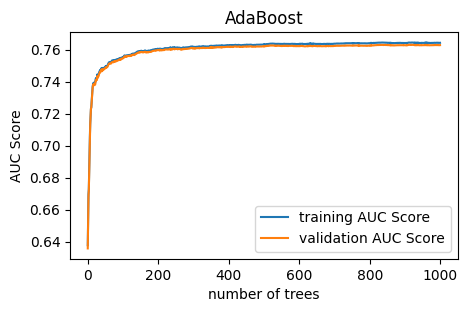

In [8]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(AUC_score_train_3)
plt.plot(AUC_score_validate_3)
#plt.ylim(0.5,0.8)
plt.xlabel('number of trees')
plt.ylabel('AUC Score')
plt.legend(['training AUC Score', 'validation AUC Score'], loc = 'best')
plt.title("AdaBoost")
plt.show()